In [ ]:
# --- Bootstrap: install missing packages & set environment ---
import sys
import subprocess
import os

required = [
    "xarray", "rioxarray", "rasterio", "geopandas", "matplotlib",
    "scipy", "openpyxl", "shapely", "pandas"
]

installed_something = False

def install_missing(packages):
    global installed_something
    for pkg in packages:
        try:
            __import__(pkg)
        except ImportError:
            print(f"📦 Installing {pkg}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
            installed_something = True

# 🛠️ Install what's missing
install_missing(required)

# 📁 Set working dir to persistent folder
os.chdir("/home/jovyan/mystorage")
print("✅ Working from:", os.getcwd())

# 🔁 Restart suggestion only if installs happened
if installed_something:
    print("⚠️ One or more packages were installed.")
    print("🔁 Please restart the kernel now, then re-run this notebook from the top.")
else:
    print("✅ All required packages are already installed.")


📦 Installing rioxarray...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 50.2 MB/s eta 0:00:001
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 10.9 MB/s eta 0:00:00
📦 Installing geopandas...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 22.2 MB/s eta 0:00:00
📦 Installing matplotlib...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
# --- Cell 1: Imports & Setup ---
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping
import shapely.ops
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import mode
import warnings
warnings.filterwarnings("ignore")

# 📁 Folder paths
input_dir = "/home/jovyan/mystorage/NPP_project/NPP_inputs/"
output_dir = "/home/jovyan/mystorage/NPP_project/NPP_outputs/"
os.makedirs(output_dir, exist_ok=True)

print("✅ Environment ready.")


✅ Environment ready.


In [23]:
import os

def check_file(path):
    size = os.path.getsize(path) / 1e6
    print(f"{os.path.basename(path)} — {size:.2f} MB")

files = [
    "/home/jovyan/mystorage/NPP_project/Conversiontables/25-04-24_conversietabel_MODIS_ESTK_LUTable_voorlopig.xlsx",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/LAI_Gelderland.tif",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/ssrd_Gelderland.tif",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/temperature_Gelderland.tif",
    "/home/jovyan/mystorage/NPP_project/NPP_inputs/ESTK_Gelderland_32631.tif",
]

for f in files:
    try:
        check_file(f)
    except:
        print(f"❌ Cannot read {f}")


25-04-24_conversietabel_MODIS_ESTK_LUTable_voorlopig.xlsx — 0.01 MB
LAI_Gelderland.tif — 333.60 MB
ssrd_Gelderland.tif — 0.00 MB
temperature_Gelderland.tif — 0.00 MB
ESTK_Gelderland_32631.tif — 118.89 MB


In [24]:
# --- Cell 2: Load the ESTK LUT from Excel ---
lut_path = "/home/jovyan/mystorage/NPP_project/Conversiontables/25-04-24_conversietabel_MODIS_ESTK_LUTable_voorlopig.xlsx"

# 📥 Load, strip whitespace, and set index to 'Pixelwaarde'
lut_df = pd.read_excel(
    "/home/jovyan/mystorage/NPP_project/Conversiontables/25-04-24_conversietabel_MODIS_ESTK_LUTable_voorlopig.xlsx",
    engine="openpyxl"
)
lut_df.columns = lut_df.columns.str.strip()  # clean column names
lut_df = lut_df.set_index("Pixelwaarde")
lut_df.index = lut_df.index.astype(int)  # ensure proper matching

# ✅ Preview
print("📋 LUT loaded with classes:", lut_df.index.tolist())
lut_df.head()


📋 LUT loaded with classes: [1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 27, 29, 30, 31, 33, 34, 37, 44, 45, 51, 52]


,ESTK omschrijving,MODIS LC class,eps_max,SLA,Leaf_resp_base,Root_resp_base,Root_Leaf_ratio,Wood_resp_base,Wood_Leaf_ratio,T_max,T_min
Pixelwaarde,,,,,,,,,,,
1,Productiebos,6,0.000962,14.1,0.00604,0.00519,1.2,0.00397,0.182,20,-8
2,Akkerbouw_reg,1,0.001044,30.4,0.00980,0.00819,2.0,0.00000,0.000,25,-8
3,Ov_nat_grasland,2,0.000860,37.5,0.00980,0.00819,2.6,0.00000,0.000,25,-8
4,Groenvoorziening,7,0.001051,21.5,0.00778,0.00519,1.1,0.00371,0.203,22,-7
7,Infra_groen,4,0.001281,9.0,0.00869,0.00519,1.0,0.00436,0.079,20,-8


In [25]:
# --- Cell 3: Load and align input rasters ---

# 🌱 LAI & FAPAR
lai = rxr.open_rasterio(f"{input_dir}LAI_Gelderland.tif", masked=True).squeeze() / 10000
fapar = rxr.open_rasterio(f"{input_dir}FAPAR_Gelderland.tif", masked=True).squeeze() / 10000

# 🌡 ERA5 Temperature (°C)
temp = rxr.open_rasterio(f"{input_dir}temperature_Gelderland.tif", masked=True).squeeze()
# 📉 Convert Kelvin to Celsius
temp = temp - 273.15

# ☀️ ERA5 DSSF (Daily Surface Solar Radiation)
dssf = rxr.open_rasterio(f"{input_dir}ssrd_Gelderland.tif", masked=True).squeeze()

# ✅ Align all rasters to LAI grid
temp = temp.rio.reproject_match(lai)
dssf = dssf.rio.reproject_match(lai)
fapar = fapar.rio.reproject_match(lai)

# 🧪 Confirm alignment
print("📐 Shapes (y, x):")
print("LAI:", lai.shape)
print("FAPAR:", fapar.shape)
print("TEMP:", temp.shape)
print("DSSF:", dssf.shape)


📐 Shapes (y, x):
LAI: (6622, 12593)
FAPAR: (6622, 12593)
TEMP: (6622, 12593)
DSSF: (6622, 12593)


In [26]:
# --- Cell 4: Load and align ESTK raster to LAI grid ---

# Load the clipped ESTK map (already subset to Gelderland)
estk_path = f"{input_dir}ESTK_Gelderland_32631.tif"
estk_clip = rxr.open_rasterio(estk_path, masked=True).squeeze()

# Reproject to match LAI (and thus all other rasters)
estk_clip_aligned = estk_clip.rio.reproject_match(lai)

# Check unique pixel classes present
unique_vals = np.unique(estk_clip_aligned.values[~np.isnan(estk_clip_aligned.values)])
print("🧩 ESTK classes found in raster:", unique_vals)


🧩 ESTK classes found in raster: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 30. 31. 32. 33. 34. 37. 38. 44.
 45. 47. 48. 49. 50. 52.]


In [ ]:
import gc  # garbage collector

# 🎯 Filter only the classes present in both ESTK raster and LUT
valid_classes = [int(v) for v in unique_vals if int(v) in lut_df.index]
print(f"✅ Will compute NPP for {len(valid_classes)} ecosystem classes.")

# 📦 Initialize empty NPP array
npp_array = xr.full_like(lai, np.nan)

for pixelwaarde in valid_classes:
    try:
        # Mask for the current ESTK class
        mask = estk_clip_aligned == pixelwaarde

        if mask.sum() == 0:
            print(f"⚠️ Pixelwaarde {pixelwaarde} not found in aligned raster — skipping.")
            continue

        # Lookup parameters
        row = lut_df.loc[pixelwaarde]
        eps_max = row["eps_max"]
        t_min = row["T_min"]
        t_max = row["T_max"]

        # Mask all variables
        temp_masked = temp.where(mask)
        fapar_masked = fapar.where(mask)
        dssf_masked = dssf.where(mask)
        #TODO: IPAR: Look at inputs, confused at exactly what they mean. The formula is relatively simple, is it biased?

        if np.isnan(temp_masked).all():
            print(f"⚠️ All values masked out for class {pixelwaarde}, skipping.")
            continue

        # 🍃 NPP formula
        temp_factor = ((temp_masked - t_min) * (t_max - temp_masked)) / ((t_max - t_min) ** 2)
        temp_factor = temp_factor.clip(min=0)

        gpp = eps_max * fapar_masked * dssf_masked
        npp = gpp * temp_factor

        # Update result array (only where this class applies)
        npp_array = npp_array.where(~mask, npp)
        

        print(f"✅ Processed Pixelwaarde {pixelwaarde}")

        # 💡 Free memory
        del mask, temp_masked, fapar_masked, dssf_masked, temp_factor, gpp, npp
        gc.collect()

    except Exception as e:
        print(f"❌ Error processing {pixelwaarde}: {e}")

✅ Will compute NPP for 29 ecosystem classes.
✅ Processed Pixelwaarde 1
✅ Processed Pixelwaarde 2
✅ Processed Pixelwaarde 3
✅ Processed Pixelwaarde 4
✅ Processed Pixelwaarde 7
✅ Processed Pixelwaarde 8
✅ Processed Pixelwaarde 9
✅ Processed Pixelwaarde 11
✅ Processed Pixelwaarde 12
✅ Processed Pixelwaarde 13
✅ Processed Pixelwaarde 14
✅ Processed Pixelwaarde 15
✅ Processed Pixelwaarde 16
✅ Processed Pixelwaarde 18
✅ Processed Pixelwaarde 19
✅ Processed Pixelwaarde 21
✅ Processed Pixelwaarde 22
✅ Processed Pixelwaarde 23
✅ Processed Pixelwaarde 24
✅ Processed Pixelwaarde 26
✅ Processed Pixelwaarde 27
✅ Processed Pixelwaarde 30
✅ Processed Pixelwaarde 31
✅ Processed Pixelwaarde 33
✅ Processed Pixelwaarde 34
✅ Processed Pixelwaarde 37
✅ Processed Pixelwaarde 44
✅ Processed Pixelwaarde 45
✅ Processed Pixelwaarde 52


In [14]:
# --- Cell 6: Save final NPP result to GeoTIFF ---

# Define output path
npp_out_path = f"{output_dir}NPP_Gelderland_May2022.tif"

# Ensure CRS is attached before export
npp_array.rio.write_crs(lai.rio.crs, inplace=True)

# Write to GeoTIFF
npp_array.rio.to_raster(npp_out_path)

print(f"✅ NPP raster saved to: {npp_out_path}")


✅ NPP raster saved to: /home/jovyan/mystorage/NPP_project/NPP_outputs/NPP_Gelderland_May2022.tif


In [28]:
print("▶️ Type:", type(npp_array))
print("🔢 Dtype:", npp_array.dtype)
print("🧮 Shape:", npp_array.shape)
print("📊 Min/Max:", float(npp_array.min()), float(npp_array.max()))
print("🌫️ All-zeros?", np.all(npp_array == 0))
print("❌ All-NaN?", np.isnan(npp_array).all())


▶️ Type: <class 'xarray.core.dataarray.DataArray'>
🔢 Dtype: float64
🧮 Shape: (6622, 12593)
📊 Min/Max: -2.5921867847987756e-15 3.90213078340525e-15
🌫️ All-zeros? <xarray.DataArray ()> Size: 1B
array(False)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
❌ All-NaN? <xarray.DataArray ()> Size: 1B
array(False)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0


In [29]:
print("📈 NPP summary stats:")
print(" - Mean:", float(npp_array.mean()))
print(" - Std Dev:", float(npp_array.std()))
print(" - # Non-zero values:", int((npp_array > 0).sum()))
print(" - # NaN values:", int(np.isnan(npp_array).sum()))
print(" - Total pixels:", int(npp_array.size))


📈 NPP summary stats:
 - Mean: 6.744779960457582e-16
 - Std Dev: 7.422352314846549e-16
 - # Non-zero values: 25450973
 - # NaN values: 52262731
 - Total pixels: 83390846


In [37]:
import numpy as np
import pandas as pd

# 🔍 Flatten array, remove NaNs
pixel_values = estk_clip_aligned.values.flatten()
pixel_values = pixel_values[~np.isnan(pixel_values)]

# 🧮 Count frequencies
value_counts = pd.Series(pixel_values).value_counts().sort_index()
value_counts = value_counts.astype(int)

# 📊 Print top 10
print("📈 Pixelwaarde frequency count (top 10):")
print(value_counts.head(10))

# Optional: show full table
# print(value_counts)


📈 Pixelwaarde frequency count (top 10):
1.0      3792797
2.0      6040727
3.0       256886
4.0       567112
5.0      3688254
6.0      1737597
7.0       281969
8.0        69854
9.0     11432871
10.0       93957
Name: count, dtype: int64


In [38]:
# Add label from LUT
value_counts_named = value_counts.rename_axis("Pixelwaarde").reset_index(name="Count")
value_counts_named["Class"] = value_counts_named["Pixelwaarde"].map(lut_df["ESTK omschrijving"])

# Sort descending
value_counts_named = value_counts_named.sort_values("Count", ascending=False)

print("📋 Top ecosystem types by pixel count:")
print(value_counts_named.head(10))

📋 Top ecosystem types by pixel count:
    Pixelwaarde     Count          Class
8           9.0  11432871   Grasland_blv
1           2.0   6040727  Akkerbouw_reg
32         34.0   3812515      Natuurbos
0           1.0   3792797   Productiebos
4           5.0   3688254            NaN
15         16.0   2637418  Grasland_tijd
16         17.0   1808928            NaN
5           6.0   1737597            NaN
29         31.0   1449247     Natuurgras
21         22.0   1258242          Heide


In [17]:
pixelwaarde = 9  # Change to any dominant class you expect

mask = estk_clip_aligned == pixelwaarde
print(f"🟡 Mask pixels for class {pixelwaarde}: {int(mask.sum())}")

row = lut_df.loc[pixelwaarde]
t_min = row["T_min"]
t_max = row["T_max"]
print(f"📏 LUT T_min/T_max: {t_min} / {t_max}")

temp_masked = temp.where(mask)
print("🌡️ TEMP stats within mask:")
print(" - Min:", float(temp_masked.min()))
print(" - Max:", float(temp_masked.max()))
print(" - Mean:", float(temp_masked.mean()))
print(" - NaN count:", int(np.isnan(temp_masked).sum()))


🟡 Mask pixels for class 9: 11432871
📏 LUT T_min/T_max: -8 / 25
🌡️ TEMP stats within mask:
 - Min: 13.888561196712033
 - Max: 15.105947001719642
 - Mean: 14.59412362255914
 - NaN count: 71957975


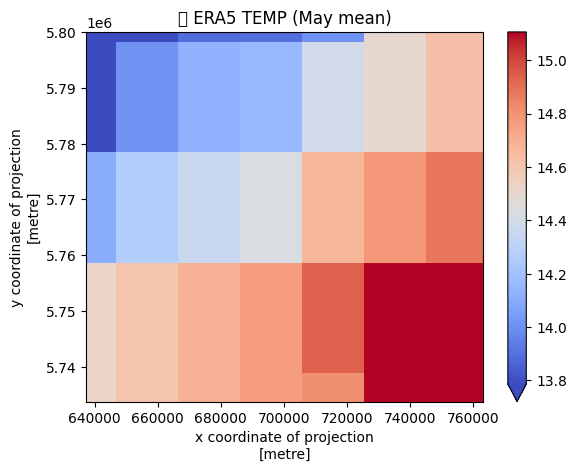

In [18]:
temp.plot(cmap="coolwarm", robust=True)
plt.title("🌡️ ERA5 TEMP (May mean)")
plt.show()


In [19]:
mask = estk_clip_aligned == 9

row = lut_df.loc[9]
t_min = row["T_min"]
t_max = row["T_max"]
eps_max = row["eps_max"]

# 🧪 Extract variables
temp_masked = temp.where(mask)
fapar_masked = fapar.where(mask)
dssf_masked = dssf.where(mask)

# ✅ Compute temp factor
temp_factor = ((temp_masked - t_min) * (t_max - temp_masked)) / ((t_max - t_min) ** 2)
temp_factor = temp_factor.clip(min=0)

print("🌡️ Temp factor stats:")
print(" - Min:", float(temp_factor.min()))
print(" - Max:", float(temp_factor.max()))
print(" - Mean:", float(temp_factor.mean()))
print(" - Non-zero pixels:", int((temp_factor > 0).sum()))


🌡️ Temp factor stats:
 - Min: 0.20992788265424359
 - Max: 0.22333646302046778
 - Mean: 0.2158379400986345
 - Non-zero pixels: 11432871


In [30]:
print("🍃 FAPAR stats:")
print(" - Min:", float(fapar_masked.min()))
print(" - Max:", float(fapar_masked.max()))
print(" - Mean:", float(fapar_masked.mean()))
print(" - NaN count:", int(np.isnan(fapar_masked).sum()))

print("🔆 DSSF stats:")
print(" - Min:", float(dssf_masked.min()))
print(" - Max:", float(dssf_masked.max()))
print(" - Mean:", float(dssf_masked.mean()))
print(" - NaN count:", int(np.isnan(dssf_masked).sum()))


🍃 FAPAR stats:


NameError: name 'fapar_masked' is not defined

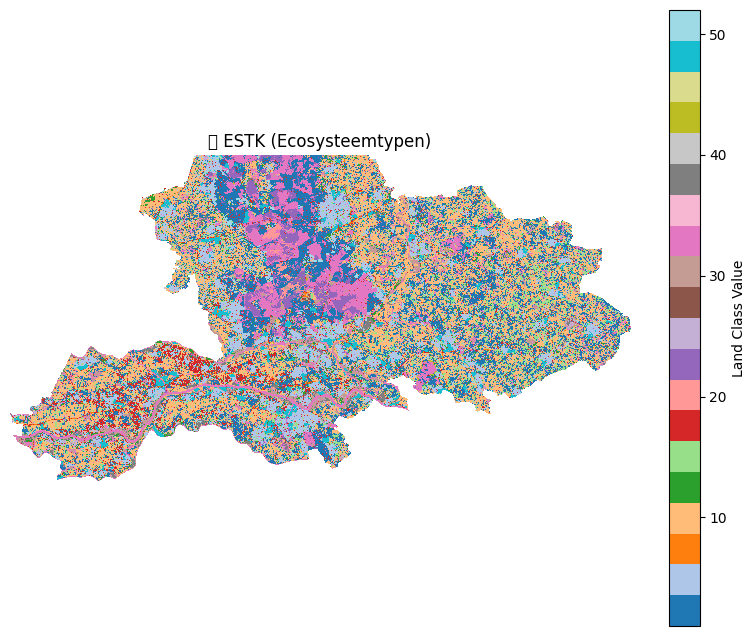

In [31]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

plt.figure(figsize=(10, 8))

# Flip Y-axis to get north-up orientation
plt.imshow(estk_clip_aligned.values[::-1], cmap="tab20", interpolation="none")
plt.title("🧩 ESTK (Ecosysteemtypen)")
plt.axis("off")
plt.colorbar(label="Land Class Value")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# 🎨 Unique values (land classes)
unique_vals = np.unique(estk_clip_aligned.values[~np.isnan(estk_clip_aligned.values)])
unique_vals = [int(v) for v in unique_vals]

# 🔠 Get ESTK labels from LUT
estk_labels = lut_df["ESTK omschrijving"].to_dict()
legend_labels = [estk_labels.get(v, f"Class {v}") for v in unique_vals]

# 🎨 Dynamic colormap
cmap = plt.cm.get_cmap("nipy_spectral", len(unique_vals))

# ✅ Fixed boundary binning
boundaries = np.array(unique_vals + [max(unique_vals)+1]) - 0.5
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(boundaries) - 1)

# 🎨 Build legend handles
legend_colors = [cmap(i) for i in range(len(unique_vals))]
handles = [
    plt.Line2D([0], [0], marker='s', color='none', markerfacecolor=c, label=l, markersize=8)
    for c, l in zip(legend_colors, legend_labels)
]

# 🖼️ Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# NPP map
axes[0].imshow(npp_array.values[::-1], cmap="YlGn", interpolation="none")
axes[0].set_title("🌱 Net Primary Production (May 2022)")
axes[0].axis("off")

# ESTK map
axes[1].imshow(estk_clip_aligned.values[::-1], cmap=cmap, norm=norm, interpolation="none")
axes[1].set_title("🧩 Ecosysteemtypen (ESTK)")
axes[1].axis("off")
axes[1].legend(handles=handles, loc='lower left', bbox_to_anchor=(1.05, 0), title="Legend", fontsize='small')

plt.tight_layout()
plt.show()


In [ ]:
# --- Cell 8: Notes and Guidance for Scaling the Workflow ---

print("🧭 Notes for Scaling the NPP Pipeline:\n")

print("1️⃣ Change Region (Province or AOI):")
print("- Update the ESTK raster clip (e.g., Utrecht, Overijssel, etc.)")
print("- Update LAI and FAPAR tiles for the matching Sentinel-2 grid")
print("- Clip temperature & DSSF rasters accordingly")

print("\n2️⃣ Change Time Period:")
print("- Update LAI/FAPAR to a different month (e.g., June)")
print("- Extract new ERA5 layers for TEMP and DSSF (monthly mean or daily sum)")
print("- Update output filenames accordingly")

print("\n3️⃣ Extend to Full Netherlands:")
print("- Consider using a tile-based loop (multiple Sentinel-2 UTM zones)")
print("- May need to mosaic LAI/FAPAR first and work with chunked rasters")
print("- Use cloud computing (e.g. CDSE, Terrascope, WEkEO) for scalability")

print("\n4️⃣ Export Options:")
print("- Use `.rio.to_raster()` to save intermediate layers (e.g. LAI_combined)")
print("- Load into QGIS or use `geopandas` to summarize by admin units")
print("- Add PNG or PDF export of plots with `plt.savefig()`")

print("\n✅ All code cells are modular — can be adapted per region/month.")
print("🏁 Done! 🚀")
